In [1]:
import pandas as pd
import configparser
import os
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

In [2]:
## Using an ini file for credentials, otherwise providing defaults
uri = "bolt://localhost:7687"   # Hoặc thay đổi nếu cổng khác
username = "neo4j"              # Tên đăng nhập của Neo4j
password = "12345678"      # Mật khẩu của Neo4j

# if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
#     config = configparser.RawConfigParser()
#     config.read(NEO4J_PROPERTIES_FILE)
#     HOST = config['NEO4J']['HOST']
#     USERNAME = config['NEO4J']['USERNAME']
#     PASSWORD = config['NEO4J']['PASSWORD']
#     print('Using custom database properties')
# else:
#     print('Could not find database properties file, using defaults')

In [4]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(uri, auth=(username, password))

In [5]:
# Machine Learning Training & Evaluation
# Get and Prepare Data
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.sharedIdsDegree AS sharedIdsDegree,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df

,guid,wccId,fraudRisk,fraudMoneyTransfer,sharedIdsDegree,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,be0222d26897046dc92ae2929d3427e7,0,0,0,0.0,0.150000,0.175463,0.414298,10.0,21.0,3.0,4.0,1,0
1,59515432f0e2e79b83e9524c94f7f86e,1,0,0,0.0,0.150000,0.310576,0.150422,10.0,7.0,1.0,1.0,1,0
2,ba1f4324c66ee093478d41a6826a3649,2,0,0,0.0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,8a18e1625e35a9f66abfd7bd2d04f0b3,3,0,0,0.0,0.150000,0.230177,0.319779,100.0,135.0,12.0,2.0,1,0
4,9f705a0107acc25a57f9e6aa8436a08e,4,0,0,0.0,0.150000,0.391428,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33726,f3693169dcc9064114a171c5c2f485b5,33726,0,0,0.0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33727,10f7f048645c602de3fae7c2cf81b254,27912,0,0,1.0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33728,d3a4469957800636802a8de4874af1bc,33728,0,0,0.0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33729,4698ccb2e4b07b1974741f634115e49b,33729,0,0,0.0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [6]:
# X: Tập dữ liệu đặc trưng đầu vào cho mô hình, loại bỏ các cột không cần thiết:
# Loại bỏ fraudRisk, fraudMoneyTransfer (vì đây là mục tiêu dự đoán).
# Loại bỏ wccId và guid (không mang giá trị cho mô hình học máy).
# X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid', 'p2pSentPageRank', 'p2pReceivedWeightedPageRank','cardDegree','p2pReceivedWeightedDegree', 'p2pSharedCardPageRank', 'deviceDegree'])
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid'])
# y: Biến mục tiêu (target variable):
# df.fraudRisk - df.fraudMoneyTransfer:
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 0 → tài khoản nguy cơ rủi ro → y = 1.
# Nếu fraudRisk = 1 và fraudMoneyTransfer = 1 → tài khoản đã chuyển tiền gian lận → y = 0.
# Nếu fraudRisk = 0 → tài khoản an toàn → y = 0.
y = df.fraudRisk - df.fraudMoneyTransfer

In [7]:
print(X)

       sharedIdsDegree  p2pSharedCardPageRank  p2pSentPageRank  \
0                  0.0               0.150000         0.175463   
1                  0.0               0.150000         0.310576   
2                  0.0               0.150000         0.277500   
3                  0.0               0.150000         0.230177   
4                  0.0               0.150000         0.391428   
...                ...                    ...              ...   
33726              0.0               0.150000         0.297005   
33727              1.0               0.999999         0.371382   
33728              0.0               0.150000         0.150000   
33729              0.0               0.150000         0.181054   
33730              0.0               0.150000         0.185296   

       p2pReceivedWeightedPageRank  p2pReceivedWeightedDegree  ipDegree  \
0                         0.414298                       10.0      21.0   
1                         0.150422                       

In [8]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
33726    0
33727    0
33728    0
33729    0
33730    0
Length: 33731, dtype: int64


In [9]:
# Chia tập train và test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# Mô hình random forest 
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=5, bootstrap=True, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=0)

Accuracy of random forrest classifier on test set: 0.84

Confusion Matrix: 


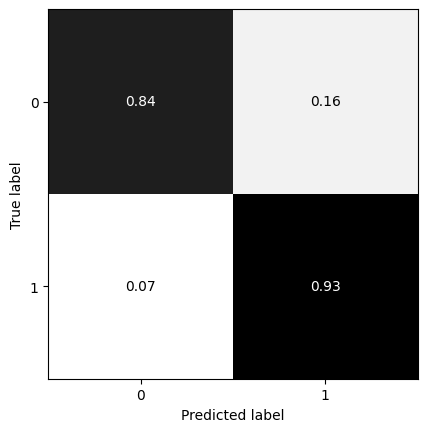

In [11]:
# Hiển thị ma trận nhầm lẫn (Confusion Matrix) để đánh giá chi tiết hiệu quả của mô hình.
# Các chỉ số trong Confusion Matrix:
# True Positive (TP): Dự đoán đúng tài khoản rủi ro.
# True Negative (TN): Dự đoán đúng tài khoản không rủi ro.
# False Positive (FP): Dự đoán nhầm tài khoản không rủi ro là rủi ro.
# False Negative (FN): Dự đoán nhầm tài khoản rủi ro là không rủi ro.
from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), display_labels=clf.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Decision Tree - Accuracy: 0.9929, Precision: 0.9911, Recall: 0.9929, F1-score: 0.9918
Accuracy of random forrest classifier on test set: 0.84

Confusion Matrix: 


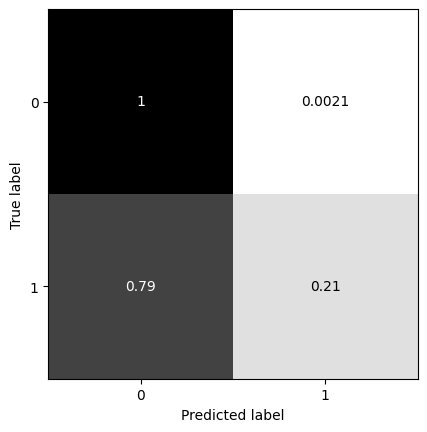

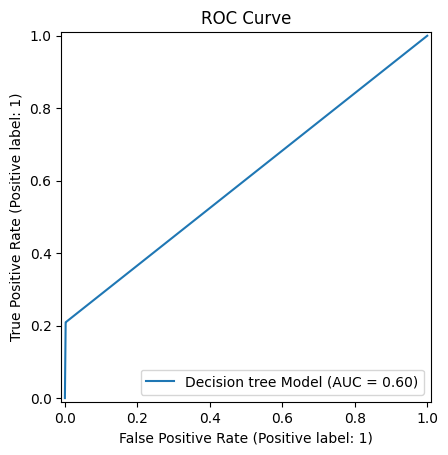

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Khởi tạo mô hình
dt_model = DecisionTreeClassifier()

# Huấn luyện mô hình
dt_model.fit(X_train, y_train)

# Dự đoán
y_pred_dt = dt_model.predict(X_test)

# Đánh giá
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print(f"Decision Tree - Accuracy: {accuracy_dt:.4f}, Precision: {precision_dt:.4f}, Recall: {recall_dt:.4f}, F1-score: {f1_dt:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, dt_model.predict(X_test), display_labels=dt_model.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(dt_model, X_test, y_test, name="Decision tree Model")
_ = display.ax_.set_title("ROC Curve")

In [ ]:
# from sklearn.svm import SVC
# 
# svm_linear = SVC(kernel='linear')
# svm_linear.fit(X_train, y_train)
# y_pred_svm_linear = svm_linear.predict(X_test)
# 
# accuracy_svm_linear = accuracy_score(y_test, y_pred_svm_linear)
# precision_svm_linear = precision_score(y_test, y_pred_svm_linear, average='weighted')
# recall_svm_linear = recall_score(y_test, y_pred_svm_linear, average='weighted')
# f1_svm_linear = f1_score(y_test, y_pred_svm_linear, average='weighted')
# 
# print(f"SVM (Linear) - Accuracy: {accuracy_svm_linear:.4f}, Precision: {precision_svm_linear:.4f}, Recall: {recall_svm_linear:.4f}, F1-score: {f1_svm_linear:.4f}")


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM (RBF) - Accuracy: 0.9936, Precision: 0.9873, Recall: 0.9936, F1-score: 0.9905
Accuracy of random forrest classifier on test set: 0.84

Confusion Matrix: 


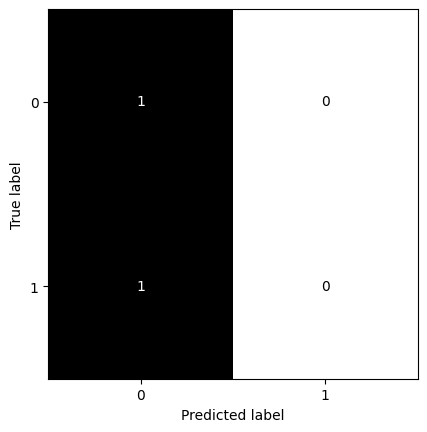

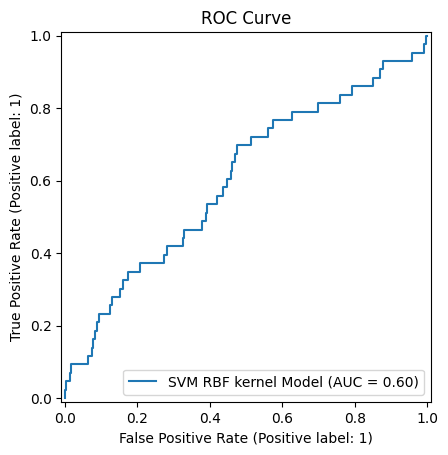

In [27]:
from sklearn.svm import SVC
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)
y_pred_svm_rbf = svm_rbf.predict(X_test)

accuracy_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
precision_svm_rbf = precision_score(y_test, y_pred_svm_rbf, average='weighted')
recall_svm_rbf = recall_score(y_test, y_pred_svm_rbf, average='weighted')
f1_svm_rbf = f1_score(y_test, y_pred_svm_rbf, average='weighted')

print(f"SVM (RBF) - Accuracy: {accuracy_svm_rbf:.4f}, Precision: {precision_svm_rbf:.4f}, Recall: {recall_svm_rbf:.4f}, F1-score: {f1_svm_rbf:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, svm_rbf.predict(X_test), display_labels=svm_rbf.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(svm_rbf, X_test, y_test, name="SVM RBF kernel Model")
_ = display.ax_.set_title("ROC Curve")

KNN - Accuracy: 0.9938, Precision: 0.9938, Recall: 0.9938, F1-score: 0.9908
Accuracy of random forrest classifier on test set: 0.84

Confusion Matrix: 


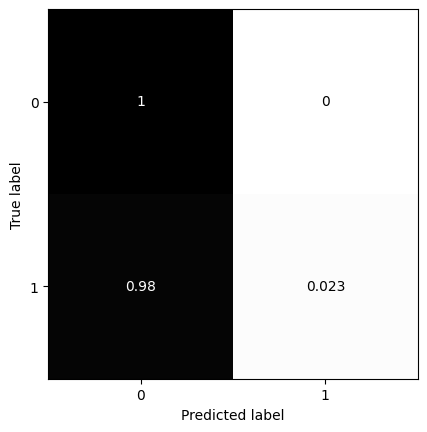

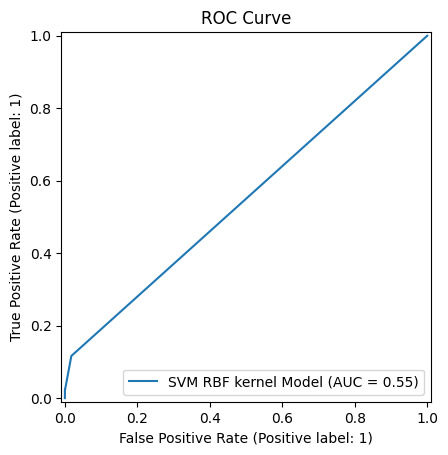

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"KNN - Accuracy: {accuracy_knn:.4f}, Precision: {precision_knn:.4f}, Recall: {recall_knn:.4f}, F1-score: {f1_knn:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, knn_model.predict(X_test), display_labels=knn_model.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(knn_model, X_test, y_test, name="SVM RBF kernel Model")
_ = display.ax_.set_title("ROC Curve")

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP - Accuracy: 0.9936, Precision: 0.9873, Recall: 0.9936, F1-score: 0.9905
Accuracy of random forrest classifier on test set: 0.84

Confusion Matrix: 


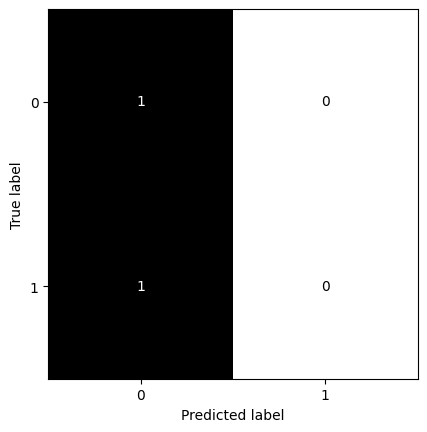

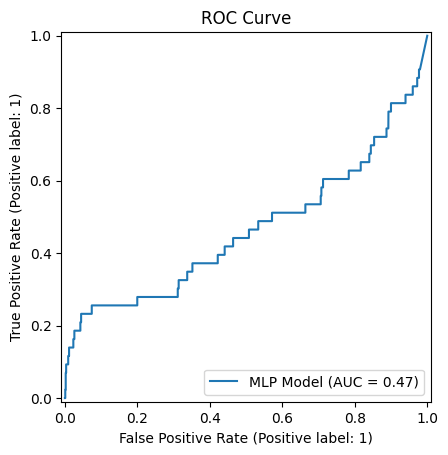

In [31]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

print(f"MLP - Accuracy: {accuracy_mlp:.4f}, Precision: {precision_mlp:.4f}, Recall: {recall_mlp:.4f}, F1-score: {f1_mlp:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, mlp_model.predict(X_test), display_labels=mlp_model.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(mlp_model, X_test, y_test, name="MLP Model")
_ = display.ax_.set_title("ROC Curve")

Naive Bayes - Accuracy: 0.9790, Precision: 0.9876, Recall: 0.9790, F1-score: 0.9832
Accuracy of random forrest classifier on test set: 0.84

Confusion Matrix: 


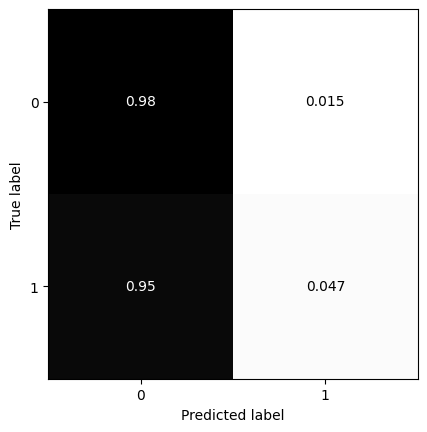

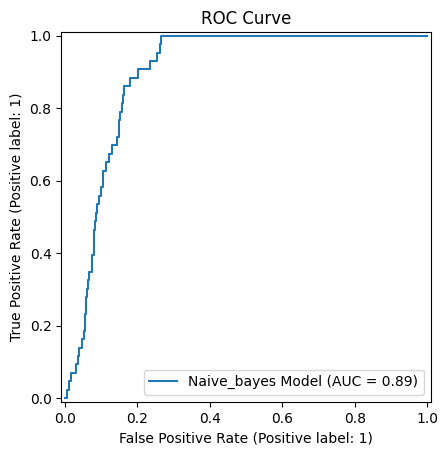

In [32]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

print(f"Naive Bayes - Accuracy: {accuracy_nb:.4f}, Precision: {precision_nb:.4f}, Recall: {recall_nb:.4f}, F1-score: {f1_nb:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, nb_model.predict(X_test), display_labels=nb_model.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(nb_model, X_test, y_test, name="Naive_bayes Model")
_ = display.ax_.set_title("ROC Curve")

Bagging - Accuracy: 0.9939, Precision: 0.9920, Recall: 0.9939, F1-score: 0.9920
Accuracy of random forrest classifier on test set: 0.84

Confusion Matrix: 


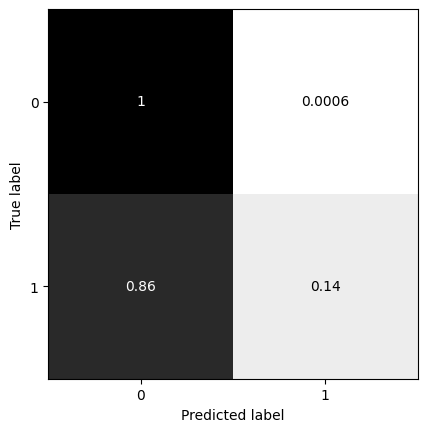

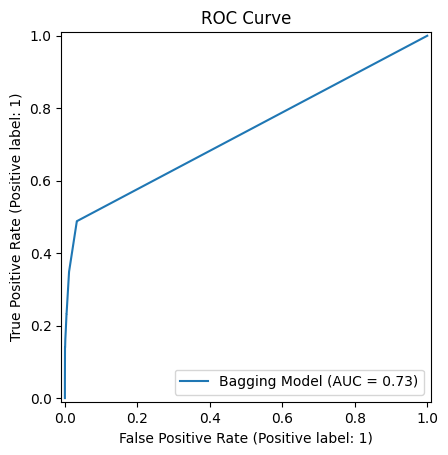

In [33]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

print(f"Bagging - Accuracy: {accuracy_bagging:.4f}, Precision: {precision_bagging:.4f}, Recall: {recall_bagging:.4f}, F1-score: {f1_bagging:.4f}")

from sklearn.metrics import ConfusionMatrixDisplay
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, bagging_model.predict(X_test), display_labels=bagging_model.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(bagging_model, X_test, y_test, name="Bagging Model")
_ = display.ax_.set_title("ROC Curve")

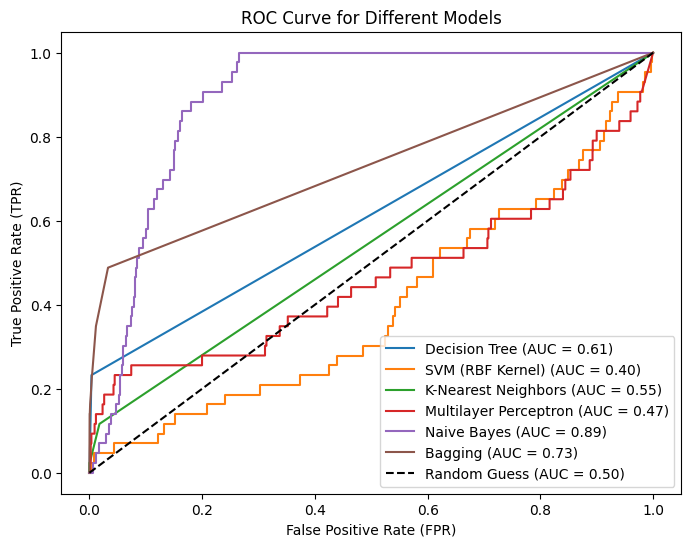

In [22]:
# Import các mô hình
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test, model_name):
    """
    Vẽ đường cong ROC cho mô hình được cung cấp
    """
    y_prob = model.predict_proba(X_test)[:, 1]  # Lấy xác suất của lớp dương (1)
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Tính FPR, TPR
    roc_auc = auc(fpr, tpr)  # Tính diện tích dưới đường cong ROC (AUC)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')  # Vẽ đường ROC

# Danh sách mô hình
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Multilayer Perceptron": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
}

plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    model.fit(X_train, y_train)  # Huấn luyện mô hình
    plot_roc_curve(model, X_test, y_test, model_name)  # Vẽ ROC

# Vẽ đường chéo ngẫu nhiên (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

# Cấu hình biểu đồ
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Different Models")
plt.legend(loc="lower right")
plt.show()
